In [1]:

from PyQt5.QtWidgets import QMainWindow, QApplication, QLineEdit, QComboBox, QDialogButtonBox, QLabel, QDialog, QPushButton, QFileDialog
from PyQt5 import uic
import sys
import all_funcs
from math import ceil
import os
import csv
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
from skimage import data
from skimage.data import astronaut
import cv2
import numpy as np
from tifffile import imwrite
from nd2reader import ND2Reader
import numpy as np
import glob
import csv
import os
from all_funcs import extract_roi_coordinates
from all_funcs import cell_size_extractor
from all_funcs import clean_roi_borders
from all_funcs import pre_clean
from all_funcs import noisify
from all_funcs import crop_using_roi_tuple
from skimage.measure import label, regionprops, regionprops_table
import math
import pickle

In [2]:

output_path="/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/"


In [37]:
import pandas as pd
import numpy as np

# Load the CSV file once
df = pd.read_csv("/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/BF2/cell_0/AllPos_acdc_output/AllPos_acdc_output_BF_cell_cycle.csv")

# Get unique Cell_IDs
unique_cell_ids = np.unique(df['Cell_ID'])

grand_dict = dict() #key is mother index

# Loop through each unique Cell ID
for cell_id in unique_cell_ids:
    time_history = []
    for frame in range(26):  # Iterate through each time frame
        # Create a DataFrame for the current timepoint
        df_timepoint = df[df['frame_i'] == frame]

        # Check if the Cell_ID exists in the current timepoint DataFrame
        if cell_id in df_timepoint['Cell_ID'].values:
            print(cell_id)  # Print the Cell ID
           
            # Check if it is a mother
            is_mother = df_timepoint[df_timepoint["Cell_ID"] == (cell_id)]["relationship"].eq("mother").any()
            if is_mother:
                #add the relative_ID, -1 means its a G1 mother
                time_history.append(list(df_timepoint[df_timepoint["Cell_ID"]==cell_id]["relative_ID"])[0])
            else:
                time_history.append(0)
        else:
                time_history.append(0)                
    grand_dict[str(cell_id)]=time_history


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
6
6
6
6
6
6
6
6
6
6
6
8
8
8
8
8
8
8
10
10
10
10
10
10
12
12
12


In [36]:
#Code to save a dictionary corresponding to
#relativeID,Cell-CycleStage,Relationship (bud or mother) for each time-point

import pandas as pd
import numpy as np

# Load the CSV file once
df = pd.read_csv("/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/BF2/cell_0/AllPos_acdc_output/AllPos_acdc_output_BF_cell_cycle.csv")

# Get unique Cell_IDs
unique_cell_ids = np.unique(df['Cell_ID'])

##For each mask ID/region as the following in each iteration with the key as the mask ID for the dictionary
relative_IDs = dict() #what is the ID of your relative (if any?)
cc_stage = dict() #what stage for the cell-cycle are you in?
identity = dict() #are you mother or a bud?


# Loop through each unique Cell ID
for cell_id in unique_cell_ids:

    time_history_relativeID = []
    time_history_cc_stage = []
    time_history_identity = []

    for frame in range(26):  # Iterate through each time frame
        # Create a DataFrame for the current timepoint
        df_timepoint = df[df['frame_i'] == frame]

        # Check if the Cell_ID exists in the current timepoint DataFrame
        
        if cell_id in df_timepoint['Cell_ID'].values:
            print(cell_id)  # Print the Cell ID
            
            # Check if it is a G1 mother
            is_in_G1 = df_timepoint[df_timepoint["Cell_ID"] == (cell_id)]["cell_cycle_stage"].eq("G1").any()
            
            if is_in_G1:
                #add the relative_ID, -1 means its a G1 mother
                time_history_relativeID.append(-1)
                time_history_identity.append("mother")
                time_history_cc_stage.append("G1")
            else:
                time_history_relativeID.append(list(df_timepoint[df_timepoint["Cell_ID"]==cell_id]["relative_ID"])[0])
                time_history_cc_stage.append("S")
                time_history_identity.append(list(df_timepoint[df_timepoint["Cell_ID"]==cell_id]["relationship"])[0])
        else:
            #The ID doesn't exist at this time_point time-frame
                time_history_relativeID.append(np.nan)
                time_history_cc_stage.append(np.nan)
                time_history_identity.append(np.nan)


    relative_IDs[str(cell_id)]=time_history_relativeID
    cc_stage[str(cell_id)]=time_history_cc_stage
    identity[str(cell_id)]=time_history_identity

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
6
6
6
6
6
6
6
6
6
6
6
8
8
8
8
8
8
8
10
10
10
10
10
10
12
12
12


In [72]:
#make mask zstack

def make_mask_zstack(mask_image,num_z_slices): ##TESTED
    zstack = np.empty((34,np.shape(mask_image)[0],np.shape(mask_image)[1]))
    for z in range(num_z_slices):
        zstack[z]=mask_image
    return zstack

def ellipse_volume(mask): #assumes there's just one cell region, fits it with an ellipse and spits out the volume --ΤΕSTED
    return (np.pi*regionprops(mask)[0].axis_major_length*regionprops(mask)[0].axis_minor_length*regionprops(mask)[0].axis_minor_length*0.156*0.156*0.156/6)

# def vacuole_segmenter(path_to_multipage_tiff): #takes in a multi-page tiff, segments it and returns it -- TESTED
#     import tifffile as tiff
#     import numpy as np
#     from skimage import io, filters, measure


#     # Read the multi-page TIFF image
#     img = tiff.imread(path_to_multipage_tiff)

#     zstack_med = np.empty((img.shape[0],np.shape(img[0])[0],np.shape(img[0])[1]))
#     vac_hstack = img[0]
#     zstack_med[0] = median(np.array(img[0]),disk(4))
#     # Loop through each frame in the image
    
#     for i in range(1,img.shape[0]):

#         vac_hstack = np.hstack((vac_hstack,img[i]))
#         zstack_med[i] = median(np.array(img[i]),disk(4))

#     image = np.array(vac_hstack)
#     med = median(image, disk(4))
#     thresholds = threshold_otsu(med) #threshold for the stack

#     vac_segmented = zstack_med
#     vac_segmented[vac_segmented<thresholds]=0
#     vac_segmented[vac_segmented>0]=1
#     #imwrite("test.tif",np.array(vac_segmented).astype("uint16"),imagej=True)
#     return vac_segmented

import cv2
import numpy as np

def crop_zeros(image):
    """
    Crop out the zeros (background) from the image.

    :param image: A 2D NumPy array representing the image (grayscale).
    :return: Cropped image without the zeros (background).
    """
    # Convert image to a binary mask where 0 is the background
    # and non-zero is the foreground (object of interest)
    binary_mask = image != 0
    
    # Find the non-zero points (i.e., the object in the image)
    rows = np.any(binary_mask, axis=1)
    cols = np.any(binary_mask, axis=0)

    # Find the bounding box of the non-zero region
    top, bottom = np.argmax(rows), len(rows) - np.argmax(rows[::-1]) - 1
    left, right = np.argmax(cols), len(cols) - np.argmax(cols[::-1]) - 1

    # Crop the image using the bounding box
    cropped_image = image[top-10:bottom+10, left-10:right+10]
    
    return cropped_image


def crop_mito3D_addnoise(mito_3d_image,cellmask_2d_image,mu,sigma):
    """
    Crop out the zeros (background) from the image and add backgroun noise to remaining zeros in the background

    :param mito_3d_image: A 3D NumPy array representing the mito image (grayscale).
    :param cellmask_2d_image: A 2D NumPy array representing the mask image (grayscale).
    :mu, sigma for the background noise
    :return: Cropped mito image without minimal (background).
    """
    # Convert image to a binary mask where 0 is the background
    # and non-zero is the foreground (object of interest)
    binary_mask = cellmask_2d_image != 0
    
    # Find the non-zero points (i.e., the object in the image)
    rows = np.any(binary_mask, axis=1)
    cols = np.any(binary_mask, axis=0)

    # Find the bounding box of the non-zero region
    top, bottom = np.argmax(rows), len(rows) - np.argmax(rows[::-1]) - 1
    left, right = np.argmax(cols), len(cols) - np.argmax(cols[::-1]) - 1
    
    cropped_mask = cellmask_2d_image[top-10:bottom+10, left-10:right+10]

    zstack = np.empty((34,np.shape(cropped_mask)[0],np.shape(cropped_mask)[1]))
    for z in range(34):
        zstack[z]=noisify(mito_3d_image[z,top-10:bottom+10, left-10:right+10],mu,sigma)
    return zstack



In [ ]:
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.filters import median
from skimage.morphology import disk
import scienceplots

#Test the ellipse vol function
mask_image = cv2.imread("/Users/YeastMan/Documents/Data/FA24/AgarosePadTimelapse/YNBD+Lys/Output/BF2/cell_3_masks/pos1_BF_20.tif",-1)
mask_image[mask_image>0]=1
x=ellipse_volume(mask_image)
print(x)


#Make a mask z-stack using the make_mask_zstack function

mask_image = cv2.imread("/Users/YeastMan/Documents/Data/FA24/AgarosePadTimelapse/YNBD+Lys/Output/BF2/cell_3_masks/pos1_BF_20.tif",-1)
mask_image[mask_image>0]=1
mask3d = make_mask_zstack(mask_image, 17)
print(np.shape(mask3d))



#Test piece of code

vac_path = "/Users/YeastMan/Documents/Data/FA24/AgarosePadTimelapse/YNBD+Lys/Output/Vac/cell_0/"
x=vacuole_segmenter(vac_path+"pos1_Vac_20.tif")
print(np.shape(x))


#Test if numpy multiplication works in 3D
vac_masked = np.multiply(mask3d,x)
print(np.shape(vac_masked))



#See if a 32 bit mask image can be read
mask_image = cv2.imread("/Users/YeastMan/Documents/Data/FA24/AgarosePadTimelapse/YNBD+Lys/Output/BF2/cell_0/masks/mask0000.tif",-1)
mask_image = np.array(mask_image).astype("uint16")
print(np.max(mask_image))


(34, 412, 396)


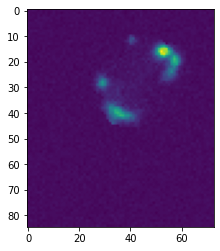

In [76]:
#Test generation of cell masks
mask_path = "/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/BF2/cell_0/masks/"
mask_image = cv2.imread(mask_path+"mask000"+str(0)+'.tif',-1)
cell_mask = mask_image.astype('uint16')
cell_mask[(cell_mask != int(2)) & (cell_mask != int(3))] = 0
cell_mask[cell_mask>0] = 1
plt.imshow(cell_mask)


# Load the image (ensure it is grayscale)
mask = cv2.imread('/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/masks/cell_id_1_t_24.tif',-1)
mask=np.array(mask)
image = tiff.imread('/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/Mito/cell_id_1_t_24.tif')  # Replace 'image.png' with your image file path
image = np.array(image)
print(np.shape(image))
crop_img=crop_mito3D_addnoise(image,mask,100,2)
crop_mask = crop_zeros(mask)
plt.imshow(crop_img[17])
#plt.imshow(crop_mask)



### Now for each cell ID, I need to make go through each time step -> find who its buds are if any, modify the mask by making everything else black in the mask -> apply to vac_max image and extract vacuole area after otsu binarization and plot the trajectory vs time

In [78]:
### Using the dictionaries for relativeIDs, identity and CC stage, this script makes a CSV corresponding to each mask ID
### and contains the following columns:

#### 1. RelativeID
#### 2. CC Stage
#### 3. Identity
#### 4. Cell Volume


    #relative_IDs[str(cell_id)]
    #cc_stage[str(cell_id)]
    #identity[str(cell_id)]

import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.filters import median
from skimage.morphology import disk
import scienceplots
import math
import tifffile as tiff

unique_cell_ids = np.unique(df['Cell_ID'])
mito_path = "/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/Mito/cell_0/"
mask_path = "/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/BF2/cell_0/masks/"

#unique_cell_ids

for cell_id in unique_cell_ids:
    
    output = pd.DataFrame()
    cell_vol = []
    relative_vol = []

    mother_vol=[]
    bud_vol = []

    for time in range(26):

        ##Initialize a mask image for that time point

        if time<10:
           
            relative_id = relative_IDs[str(cell_id)][time]
            #cell_cyc = cc_stage[str(cell_id)][time]
            iden = identity[str(cell_id)][time]

            if math.isnan(relative_id): #the mask ID doesn't exist yet
                
                cell_vol.append(np.nan)
                relative_vol.append(np.nan)


            elif relative_id>0: #the cell is in S/G2/M phase

                #Find if the cell is a bud or a mother

                if iden=="mother":
                    bud_id = relative_id #this is the bud
                    mother_id = cell_id #this is the mother
                elif iden=="bud":
                    bud_id = cell_id #this is the bud
                    mother_id = relative_id #this is the mother

                else:
                    print("wtf")

                mask_image = cv2.imread(mask_path+"mask000"+str(time)+'.tif',-1)
                mother_mask = mask_image.astype('uint16') #mask is saved as a 32bit image from FiJi
                mother_mask[mother_mask!=int(mother_id)]=0
                mother_mask[mother_mask>0]=1
                
                #mother_mask_3D = make_mask_zstack(mother_mask, 34)

                
                mask_image = cv2.imread(mask_path+"mask000"+str(time)+'.tif',-1)
                bud_mask=mask_image.astype('uint16')
                bud_mask[bud_mask!=bud_id]=0
                bud_mask[bud_mask>0]=1
                #bud_mask_3D = make_mask_zstack(bud_mask, 34)

                mask_image = cv2.imread(mask_path+"mask000"+str(time)+'.tif',-1)
                cell_mask = mask_image.astype('uint16')
                cell_mask[(cell_mask!=int(mother_id)) & (cell_mask!=int(bud_id))]=0
                cell_mask[cell_mask>0] = 1
                cell_mask_3D = make_mask_zstack(cell_mask, 34)
                mito_img = tiff.imread(mito_path+"pos1_mito_"+str(time)+'.tif')

                # mother_mito = np.multiply(mito_img,mother_mask_3D)
                # bud_mito = np.multiply(mito_img,bud_mask_3D)
                cell_mito = np.multiply(mito_img,cell_mask_3D)
                cell_mito = cell_mito.astype("uint16")
                cropped_mito = crop_mito3D_addnoise(cell_mito,cell_mask,100,2).astype("uint16")

                if iden=="mother":
                    print(np.count_nonzero(mother_mask))
                    cell_vol.append(ellipse_volume(mother_mask))
                    relative_vol.append(ellipse_volume(bud_mask))

                elif iden=="bud":
                    cell_vol.append(ellipse_volume(bud_mask))
                    relative_vol.append(ellipse_volume(mother_mask))



                os.makedirs(f"{output_path}masks/", exist_ok=True)
                os.makedirs(f"{output_path}mito/", exist_ok=True)
                
                imwrite(output_path+"masks/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif', crop_zeros(cell_mask).astype("uint16"),dtype='uint16')
                imwrite(output_path+"mito/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif',cropped_mito,dtype='uint16')


            elif relative_id == -1: #its a G1 cell

                mother_id = cell_id

                 ## Then fetch the ID of the relative if any
                mask_image = cv2.imread(mask_path+"mask000"+str(time)+'.tif',-1)
                mother_mask = mask_image.astype('uint16')
                mother_mask[mother_mask!=mother_id]=0
                mother_mask[mother_mask>0]=1
                #mother_mask_3D = make_mask_zstack(mother_mask, 17)
                
                mask_image = cv2.imread(mask_path+"mask000"+str(time)+'.tif',-1)
                cell_mask = mask_image.astype('uint16')
                cell_mask[(cell_mask!=int(mother_id))]=0
                cell_mask[cell_mask>0] = 1
                cell_mask_3D = make_mask_zstack(cell_mask, 34)
                mito_img = tiff.imread(mito_path+"pos1_mito_"+str(time)+'.tif')


                # mother_vac = np.multiply(mito_segmented,mother_mask_3D)
                cell_mito = np.multiply(mito_img,cell_mask_3D)
                cell_mito = cell_mito.astype('uint16')
                cropped_mito = crop_mito3D_addnoise(cell_mito,cell_mask,100,2).astype("uint16")


                cell_vol.append(ellipse_volume(mother_mask))
                relative_vol.append(0) #bud volume is zero

                os.makedirs(f"{output_path}masks/", exist_ok=True)
                os.makedirs(f"{output_path}mito/", exist_ok=True)
                
                imwrite(output_path+"masks/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif', crop_zeros(cell_mask).astype("uint16"),dtype='uint16')
                imwrite(output_path+"mito/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif',cropped_mito,dtype='uint16')



        elif time<100:
            
            relative_id = relative_IDs[str(cell_id)][time]
            #cell_cyc = cc_stage[str(cell_id)][time]
            iden = identity[str(cell_id)][time]

            if math.isnan(relative_id): #the mask ID doesn't exist yet
                
                cell_vol.append(np.nan)
                relative_vol.append(np.nan)


            elif relative_id>0: #the cell is in S/G2/M phase

                #Find if the cell is a bud or a mother

                if iden=="mother":
                    bud_id = relative_id #this is the bud
                    mother_id = cell_id #this is the mother
                elif iden=="bud":
                    bud_id = cell_id #this is the bud
                    mother_id = relative_id #this is the mother

                else:
                    print("wtf")

                mask_image = cv2.imread(mask_path+"mask00"+str(time)+'.tif',-1)
                mother_mask = mask_image.astype('uint16') #mask is saved as a 32bit image from FiJi
                mother_mask[mother_mask!=int(mother_id)]=0
                mother_mask[mother_mask>0]=1
                
                #mother_mask_3D = make_mask_zstack(mother_mask, 34)

                
                mask_image = cv2.imread(mask_path+"mask00"+str(time)+'.tif',-1)
                bud_mask=mask_image.astype('uint16')
                bud_mask[bud_mask!=bud_id]=0
                bud_mask[bud_mask>0]=1
                #bud_mask_3D = make_mask_zstack(bud_mask, 34)

                mask_image = cv2.imread(mask_path+"mask00"+str(time)+'.tif',-1)
                cell_mask = mask_image.astype('uint16')
                cell_mask[(cell_mask!=int(mother_id)) & (cell_mask!=int(bud_id))]=0
                cell_mask[cell_mask>0] = 1
                cell_mask_3D = make_mask_zstack(cell_mask, 34)
                mito_img = tiff.imread(mito_path+"pos1_mito_"+str(time)+'.tif')

                # mother_mito = np.multiply(mito_img,mother_mask_3D)
                # bud_mito = np.multiply(mito_img,bud_mask_3D)
                cell_mito = np.multiply(mito_img,cell_mask_3D)
                #cell_mito = noisify(cell_mito,mu,sigma)
                cell_mito = cell_mito.astype("uint16")
                cropped_mito = crop_mito3D_addnoise(cell_mito,cell_mask,100,2).astype("uint16")

                if iden=="mother":
                    print(np.count_nonzero(mother_mask))
                    cell_vol.append(ellipse_volume(mother_mask))
                    relative_vol.append(ellipse_volume(bud_mask))

                elif iden=="bud":
                    cell_vol.append(ellipse_volume(bud_mask))
                    relative_vol.append(ellipse_volume(mother_mask))



                os.makedirs(f"{output_path}masks/", exist_ok=True)
                os.makedirs(f"{output_path}mito/", exist_ok=True)
                
                imwrite(output_path+"masks/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif', crop_zeros(cell_mask).astype("uint16"),dtype='uint16')
                imwrite(output_path+"mito/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif',cropped_mito,dtype='uint16')


            elif relative_id == -1: #its a G1 cell

                mother_id = cell_id

                 ## Then fetch the ID of the relative if any
                mask_image = cv2.imread(mask_path+"mask00"+str(time)+'.tif',-1)
                mother_mask = mask_image.astype('uint16')
                mother_mask[mother_mask!=mother_id]=0
                mother_mask[mother_mask>0]=1
                #mother_mask_3D = make_mask_zstack(mother_mask, 17)
                
                mask_image = cv2.imread(mask_path+"mask00"+str(time)+'.tif',-1)
                cell_mask = mask_image.astype('uint16')
                cell_mask[(cell_mask!=int(mother_id))]=0
                cell_mask[cell_mask>0] = 1
                cell_mask_3D = make_mask_zstack(cell_mask, 34)
                mito_img = tiff.imread(mito_path+"pos1_mito_"+str(time)+'.tif')


                # mother_vac = np.multiply(mito_segmented,mother_mask_3D)
                cell_mito = np.multiply(mito_img,cell_mask_3D)
                cell_mito = cell_mito.astype("uint16")
                cropped_mito = crop_mito3D_addnoise(cell_mito,cell_mask,100,2).astype("uint16")


                cell_vol.append(ellipse_volume(mother_mask))
                relative_vol.append(0) #bud volume is zero

                os.makedirs(f"{output_path}masks/", exist_ok=True)
                os.makedirs(f"{output_path}mito/", exist_ok=True)
                
                imwrite(output_path+"masks/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif', crop_zeros(cell_mask).astype("uint16"),dtype='uint16')
                imwrite(output_path+"mito/"+"cell_id_"+str(cell_id)+"_t_"+str(time)+'.tif',cropped_mito,dtype='uint16')

    
    df_out = pd.DataFrame({"Relative_IDs": relative_IDs[str(cell_id)],"CC_stage":cc_stage[str(cell_id)],"Identity":identity[str(cell_id)],"Cell_Vol":cell_vol,"Relative_vol":relative_vol})
    df_out.to_csv(output_path+str(cell_id)+".csv")
    print(output_path)


1157
1128
1062
982
1127
1079
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
975
1071
1105
1061
1040
1084
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
1109
1055
1109
1142
1024
1032
1262
1372
1452
1416
1379
1392
1289
1527
1430
1546
1377
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
/Users/saranshumale/Documents/Data/MitoNetwork_Project/AgarPadAnalysis/Nov25_29_acdc/Gal/Output/
